In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import beta
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully")

Libraries imported successfully


In [3]:
# Generate realistic A/B test data
print("GENERATING A/B TEST DATA")
print("*"*60)

np.random.seed(42)

# Scenario: E-commerce website testing new checkout design
# Metric: Conversion rate (did user complete purchase?)

# Control Group (A) - Current design
n_control = 10000
conversion_rate_control = 0.12  # 12% conversion rate
conversions_control = np.random.binomial(1, conversion_rate_control, n_control)

# Treatment Group (B) - New design  
n_treatment = 10000
conversion_rate_treatment = 0.135  # 13.5% conversion rate (1.5% absolute lift)
conversions_treatment = np.random.binomial(1, conversion_rate_treatment, n_treatment)

# Create DataFrame
control_df = pd.DataFrame({
    'user_id': range(1, n_control + 1),
    'group': 'A (Control)',
    'converted': conversions_control,
    'revenue': conversions_control * np.random.gamma(50, 2, n_control)  # Average $100 order
})

treatment_df = pd.DataFrame({
    'user_id': range(n_control + 1, n_control + n_treatment + 1),
    'group': 'B (Treatment)',
    'converted': conversions_treatment,
    'revenue': conversions_treatment * np.random.gamma(52, 2, n_treatment)  # Slightly higher
})

# Combine
ab_data = pd.concat([control_df, treatment_df], ignore_index=True)

print(f"Total users: {len(ab_data):,}")
print(f"Control group: {len(control_df):,}")
print(f"Treatment group: {len(treatment_df):,}")

print("\nFirst 10 rows:")
print(ab_data.head(10))

# Save data
ab_data.to_csv('../data/ab_test_data.csv', index=False)
print("\nData saved to data/ab_test_data.csv")

GENERATING A/B TEST DATA
************************************************************
Total users: 20,000
Control group: 10,000
Treatment group: 10,000

First 10 rows:
   user_id        group  converted     revenue
0        1  A (Control)          0    0.000000
1        2  A (Control)          1  107.823878
2        3  A (Control)          0    0.000000
3        4  A (Control)          0    0.000000
4        5  A (Control)          0    0.000000
5        6  A (Control)          0    0.000000
6        7  A (Control)          0    0.000000
7        8  A (Control)          0    0.000000
8        9  A (Control)          0    0.000000
9       10  A (Control)          0    0.000000

Data saved to data/ab_test_data.csv


A/B TEST SUMMARY
************************************************************
               Users  Conversions  Conversion Rate  Total Revenue  \
group                                                               
A (Control)    10000         1145           0.1145    114128.2559   
B (Treatment)  10000         1409           0.1409    146870.6412   

               Revenue per User  
group                            
A (Control)             11.4128  
B (Treatment)           14.6871  

************************************************************
KEY METRICS:
Control Conversion Rate: 0.1145 (11.45%)
Treatment Conversion Rate: 0.1409 (14.09%)
Absolute Lift: 0.0264 (2.64 percentage points)
Relative Lift: 23.06%


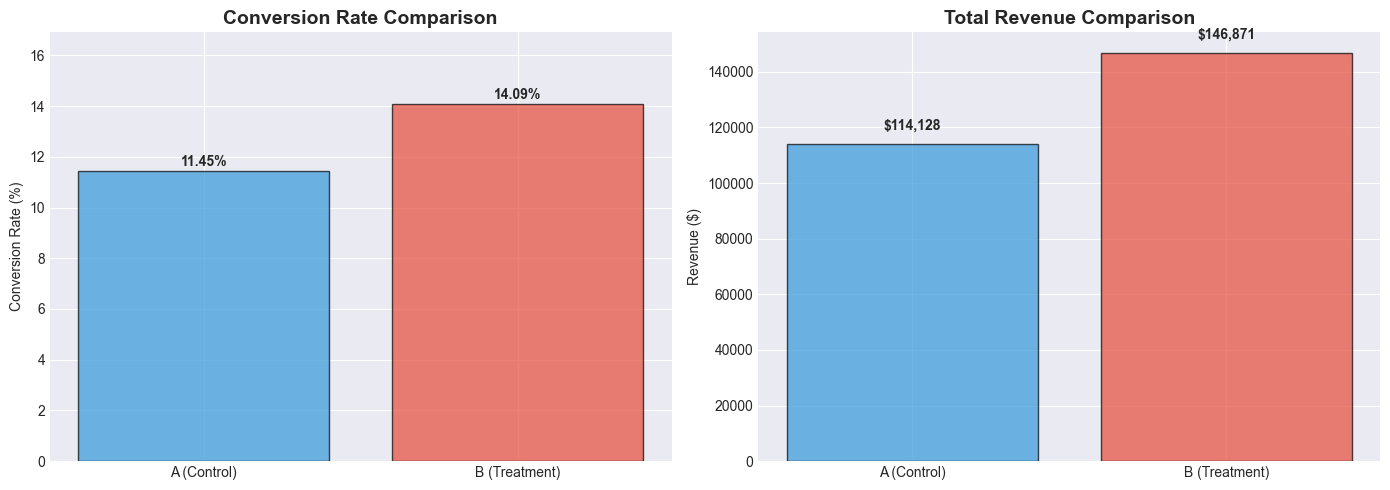


Initial analysis complete


In [5]:
# Basic A/B Test Analysis
print("A/B TEST SUMMARY")
print("*"*60)

# Group statistics
summary = ab_data.groupby('group').agg({
    'user_id': 'count',
    'converted': ['sum', 'mean'],
    'revenue': ['sum', 'mean']
}).round(4)

summary.columns = ['Users', 'Conversions', 'Conversion Rate', 'Total Revenue', 'Revenue per User']
print(summary)

# Calculate key metrics
control_conv_rate = ab_data[ab_data['group'] == 'A (Control)']['converted'].mean()
treatment_conv_rate = ab_data[ab_data['group'] == 'B (Treatment)']['converted'].mean()

absolute_lift = treatment_conv_rate - control_conv_rate
relative_lift = (absolute_lift / control_conv_rate) * 100

print("\n" + "*"*60)
print("KEY METRICS:")
print(f"Control Conversion Rate: {control_conv_rate:.4f} ({control_conv_rate*100:.2f}%)")
print(f"Treatment Conversion Rate: {treatment_conv_rate:.4f} ({treatment_conv_rate*100:.2f}%)")
print(f"Absolute Lift: {absolute_lift:.4f} ({absolute_lift*100:.2f} percentage points)")
print(f"Relative Lift: {relative_lift:.2f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Conversion rates
groups = ['A (Control)', 'B (Treatment)']
conv_rates = [control_conv_rate * 100, treatment_conv_rate * 100]
colors = ['#3498db', '#e74c3c']

axes[0].bar(groups, conv_rates, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('Conversion Rate Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Conversion Rate (%)')
axes[0].set_ylim(0, max(conv_rates) * 1.2)

# Add values on bars
for i, v in enumerate(conv_rates):
    axes[0].text(i, v + 0.2, f'{v:.2f}%', ha='center', fontweight='bold')

# Revenue comparison
control_revenue = ab_data[ab_data['group'] == 'A (Control)']['revenue'].sum()
treatment_revenue = ab_data[ab_data['group'] == 'B (Treatment)']['revenue'].sum()
revenues = [control_revenue, treatment_revenue]

axes[1].bar(groups, revenues, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_title('Total Revenue Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Revenue ($)')

# Add values on bars
for i, v in enumerate(revenues):
    axes[1].text(i, v + 5000, f'${v:,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nInitial analysis complete")

In [6]:
# Statistical Significance Testing
print("STATISTICAL SIGNIFICANCE TESTS")
print("*"*60)

# Extract data
control_conversions = ab_data[ab_data['group'] == 'A (Control)']['converted']
treatment_conversions = ab_data[ab_data['group'] == 'B (Treatment)']['converted']
print(f"Control conversions: {control_conversions.sum()}, Treatment conversions: {treatment_conversions.sum()}")

STATISTICAL SIGNIFICANCE TESTS
************************************************************
Control conversions: 1145, Treatment conversions: 1409


In [9]:
# Two-Proportion Z-Test (The most common test)
from statsmodels.stats.proportion import proportions_ztest

conversions = np.array([treatment_conversions.sum(), control_conversions.sum()])
nobs = np.array([len(treatment_conversions), len(control_conversions)])

z_stat, p_value = proportions_ztest(conversions, nobs, alternative='larger')

print("\n1. TWO-PROPORTION Z-TEST")
print("*" * 60)
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Significance level (α): 0.05")

if p_value < 0.05:
    print("RESULT: Statistically significant! Reject null hypothesis.")
    print("   Treatment is significantly better than Control.")
else:
    print("RESULT: Not statistically significant. Cannot reject null hypothesis.")
    print("   Difference could be due to random chance.")


1. TWO-PROPORTION Z-TEST
************************************************************
Z-statistic: 5.5932
P-value: 0.000000
Significance level (α): 0.05
RESULT: Statistically significant! Reject null hypothesis.
   Treatment is significantly better than Control.


In [11]:
# Calculate Confidence Interval for the difference
from statsmodels.stats.proportion import proportion_confint

# Confidence intervals for each group
control_ci = proportion_confint(control_conversions.sum(), len(control_conversions), alpha=0.05, method='normal')
treatment_ci = proportion_confint(treatment_conversions.sum(), len(treatment_conversions), alpha=0.05, method='normal')

print("\n2. 95% CONFIDENCE INTERVALS")
print("*" * 60)
print(f"Control CI: [{control_ci[0]:.4f}, {control_ci[1]:.4f}] or [{control_ci[0]*100:.2f}%, {control_ci[1]*100:.2f}%]")
print(f"Treatment CI: [{treatment_ci[0]:.4f}, {treatment_ci[1]:.4f}] or [{treatment_ci[0]*100:.2f}%, {treatment_ci[1]*100:.2f}%]")

# Difference confidence interval (approximation)
diff_se = np.sqrt((control_conv_rate * (1 - control_conv_rate) / n_control) + 
                  (treatment_conv_rate * (1 - treatment_conv_rate) / n_treatment))
diff_ci_lower = absolute_lift - 1.96 * diff_se
diff_ci_upper = absolute_lift + 1.96 * diff_se

print(f"\nLift CI: [{diff_ci_lower:.4f}, {diff_ci_upper:.4f}] or [{diff_ci_lower*100:.2f}%, {diff_ci_upper*100:.2f}%]")

if diff_ci_lower > 0:
    print("Confidence interval does NOT include 0 → Treatment is better!")
else:
    print("Confidence interval includes 0 → Result uncertain")


2. 95% CONFIDENCE INTERVALS
************************************************************
Control CI: [0.1083, 0.1207] or [10.83%, 12.07%]
Treatment CI: [0.1341, 0.1477] or [13.41%, 14.77%]

Lift CI: [0.0172, 0.0356] or [1.72%, 3.56%]
Confidence interval does NOT include 0 → Treatment is better!


In [15]:
# Effect Size (Practical Significance)
print("\n3. EFFECT SIZE")
print("*" * 60)
print(f"Absolute Lift: {absolute_lift*100:.2f} percentage points")
print(f"Relative Lift: {relative_lift:.2f}%")

if relative_lift > 10:
    print("PRACTICAL SIGNIFICANCE: High business impact (>10% lift)")
elif relative_lift > 5:
    print("PRACTICAL SIGNIFICANCE: Moderate business impact (5-10% lift)")
else:
    print("PRACTICAL SIGNIFICANCE: Small business impact (<5% lift)")


3. EFFECT SIZE
************************************************************
Absolute Lift: 2.64 percentage points
Relative Lift: 23.06%
PRACTICAL SIGNIFICANCE: High business impact (>10% lift)


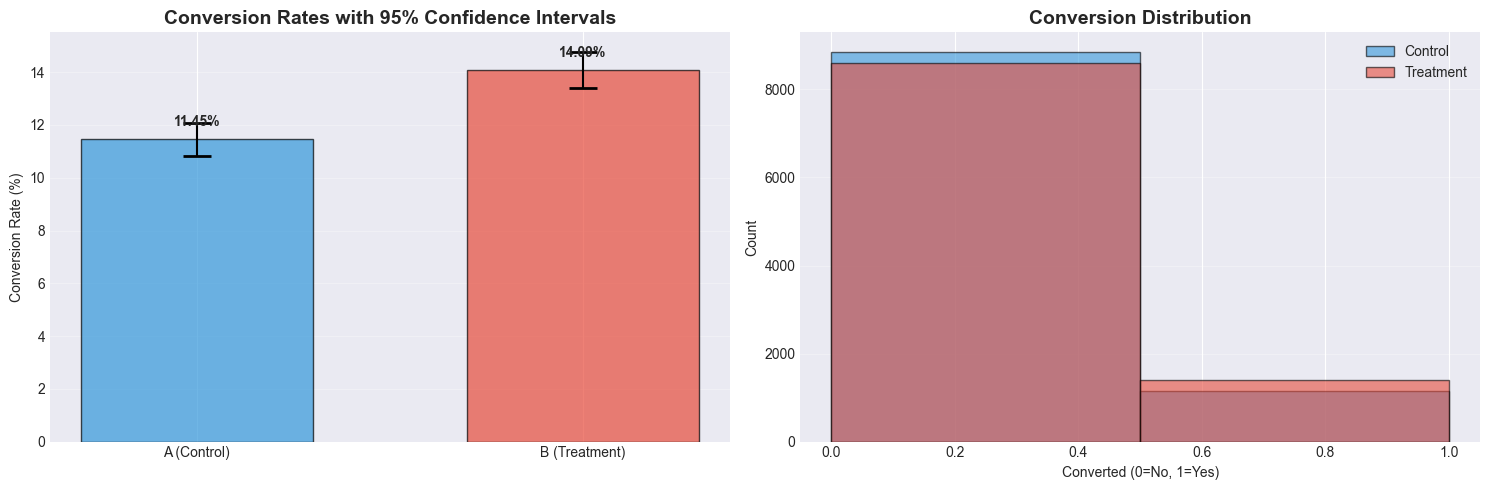


************************************************************
Statistical testing complete


In [14]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Conversion rate with confidence intervals
groups_x = [0, 1]
rates = [control_conv_rate * 100, treatment_conv_rate * 100]
ci_lower = [control_ci[0] * 100, treatment_ci[0] * 100]
ci_upper = [control_ci[1] * 100, treatment_ci[1] * 100]
errors = [[rates[i] - ci_lower[i] for i in range(2)], 
          [ci_upper[i] - rates[i] for i in range(2)]]

axes[0].bar(groups_x, rates, color=['#3498db', '#e74c3c'], 
            alpha=0.7, edgecolor='black', width=0.6)
axes[0].errorbar(groups_x, rates, yerr=errors, fmt='none', 
                 ecolor='black', capsize=10, capthick=2)
axes[0].set_xticks(groups_x)
axes[0].set_xticklabels(['A (Control)', 'B (Treatment)'])
axes[0].set_ylabel('Conversion Rate (%)')
axes[0].set_title('Conversion Rates with 95% Confidence Intervals', 
                  fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add values
for i, v in enumerate(rates):
    axes[0].text(i, v + 0.5, f'{v:.2f}%', ha='center', fontweight='bold')

# Distribution visualization
axes[1].hist(control_conversions, bins=2, alpha=0.6, label='Control', 
            color='#3498db', edgecolor='black')
axes[1].hist(treatment_conversions, bins=2, alpha=0.6, label='Treatment', 
            color='#e74c3c', edgecolor='black')
axes[1].set_xlabel('Converted (0=No, 1=Yes)')
axes[1].set_ylabel('Count')
axes[1].set_title('Conversion Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "*"*60)
print("Statistical testing complete")

POWER ANALYSIS & SAMPLE SIZE CALCULATION
************************************************************

POWER ANALYSIS INPUTS:
************************************************************
Baseline Conversion Rate: 12.0%
Minimum Detectable Effect (MDE): 1.5 percentage points
Significance Level (α): 0.05
Statistical Power: 80%
Effect Size (Cohen's h): 0.0450

REQUIRED SAMPLE SIZE:
************************************************************
Sample size per group: 7,756 users
Total sample size: 15,512 users

OUR EXPERIMENT:
************************************************************
Actual sample per group: 10,000 users
Actual total sample: 20,000 users
Sample size is SUFFICIENT (we have 1.3x the required size)

************************************************************
TEST DURATION CALCULATOR
************************************************************
Assuming 1,000 users/day
Recommended test duration: 16 days


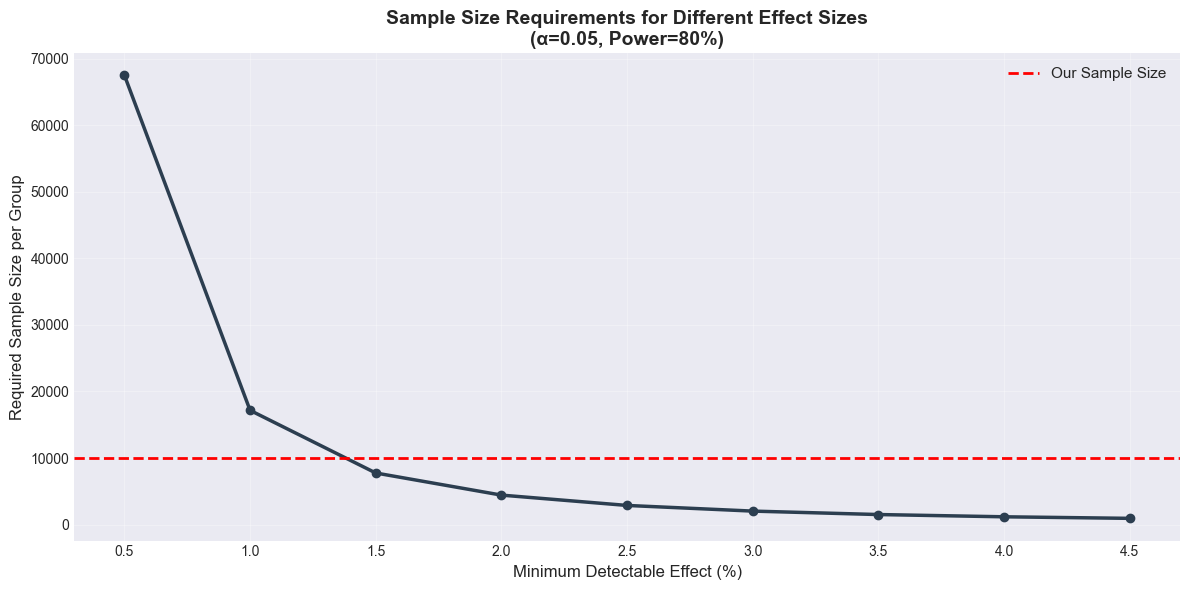


Power analysis complete


In [16]:
# Power Analysis - Sample Size Calculation
print("POWER ANALYSIS & SAMPLE SIZE CALCULATION")
print("*"*60)

from statsmodels.stats.power import zt_ind_solve_power

# Power analysis parameters
baseline_rate = 0.12  # Control conversion rate
mde = 0.015  # Minimum Detectable Effect (1.5 percentage points)
alpha = 0.05  # Significance level (Type I error)
power = 0.80  # Statistical power (80% - industry standard)

# Calculate effect size (Cohen's h for proportions)
def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

effect_size = abs(cohens_h(baseline_rate, baseline_rate + mde))

# Calculate required sample size per group
required_n = zt_ind_solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    ratio=1.0,
    alternative='two-sided'
)

print("\nPOWER ANALYSIS INPUTS:")
print("*" * 60)
print(f"Baseline Conversion Rate: {baseline_rate*100:.1f}%")
print(f"Minimum Detectable Effect (MDE): {mde*100:.1f} percentage points")
print(f"Significance Level (α): {alpha}")
print(f"Statistical Power: {power*100:.0f}%")
print(f"Effect Size (Cohen's h): {effect_size:.4f}")

print("\nREQUIRED SAMPLE SIZE:")
print("*" * 60)
print(f"Sample size per group: {int(np.ceil(required_n)):,} users")
print(f"Total sample size: {int(np.ceil(required_n)) * 2:,} users")

print("\nOUR EXPERIMENT:")
print("*" * 60)
print(f"Actual sample per group: {n_control:,} users")
print(f"Actual total sample: {n_control + n_treatment:,} users")

if n_control >= required_n:
    print(f"Sample size is SUFFICIENT (we have {n_control / required_n:.1f}x the required size)")
else:
    print(f"Sample size is INSUFFICIENT (we need {required_n / n_control:.1f}x more users)")

# Test duration calculator
print("\n" + "*"*60)
print("TEST DURATION CALCULATOR")
print("*" * 60)

daily_traffic = 1000  # Assume 1000 users per day
required_days = int(np.ceil((required_n * 2) / daily_traffic))

print(f"Assuming {daily_traffic:,} users/day")
print(f"Recommended test duration: {required_days} days")

# Visualize sample size for different effect sizes
mde_range = np.arange(0.005, 0.05, 0.005)  # 0.5% to 5% MDE
sample_sizes = []

for mde_val in mde_range:
    es = abs(cohens_h(baseline_rate, baseline_rate + mde_val))
    n = zt_ind_solve_power(effect_size=es, alpha=alpha, power=power, ratio=1.0, alternative='two-sided')
    sample_sizes.append(n)

plt.figure(figsize=(12, 6))
plt.plot(mde_range * 100, sample_sizes, linewidth=2.5, color='#2c3e50', marker='o')
plt.axhline(y=n_control, color='red', linestyle='--', linewidth=2, label='Our Sample Size')
plt.xlabel('Minimum Detectable Effect (%)', fontsize=12)
plt.ylabel('Required Sample Size per Group', fontsize=12)
plt.title('Sample Size Requirements for Different Effect Sizes\n(α=0.05, Power=80%)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("\nPower analysis complete")

BAYESIAN A/B TEST ANALYSIS
************************************************************

DATA SUMMARY:
************************************************************
Control: 1145 successes, 8855 failures
Treatment: 1409 successes, 8591 failures

BETA DISTRIBUTION PARAMETERS:
************************************************************
Control: Beta(1146, 8856)
Treatment: Beta(1410, 8592)

BAYESIAN RESULTS:
************************************************************
P(Treatment > Control): 1.0000 or 100.00%
STRONG EVIDENCE: Treatment is better (>95% probability)

Expected Lift: 2.64 percentage points
Lift Standard Deviation: 0.47 percentage points
95% Credible Interval for Lift: [1.71%, 3.57%]


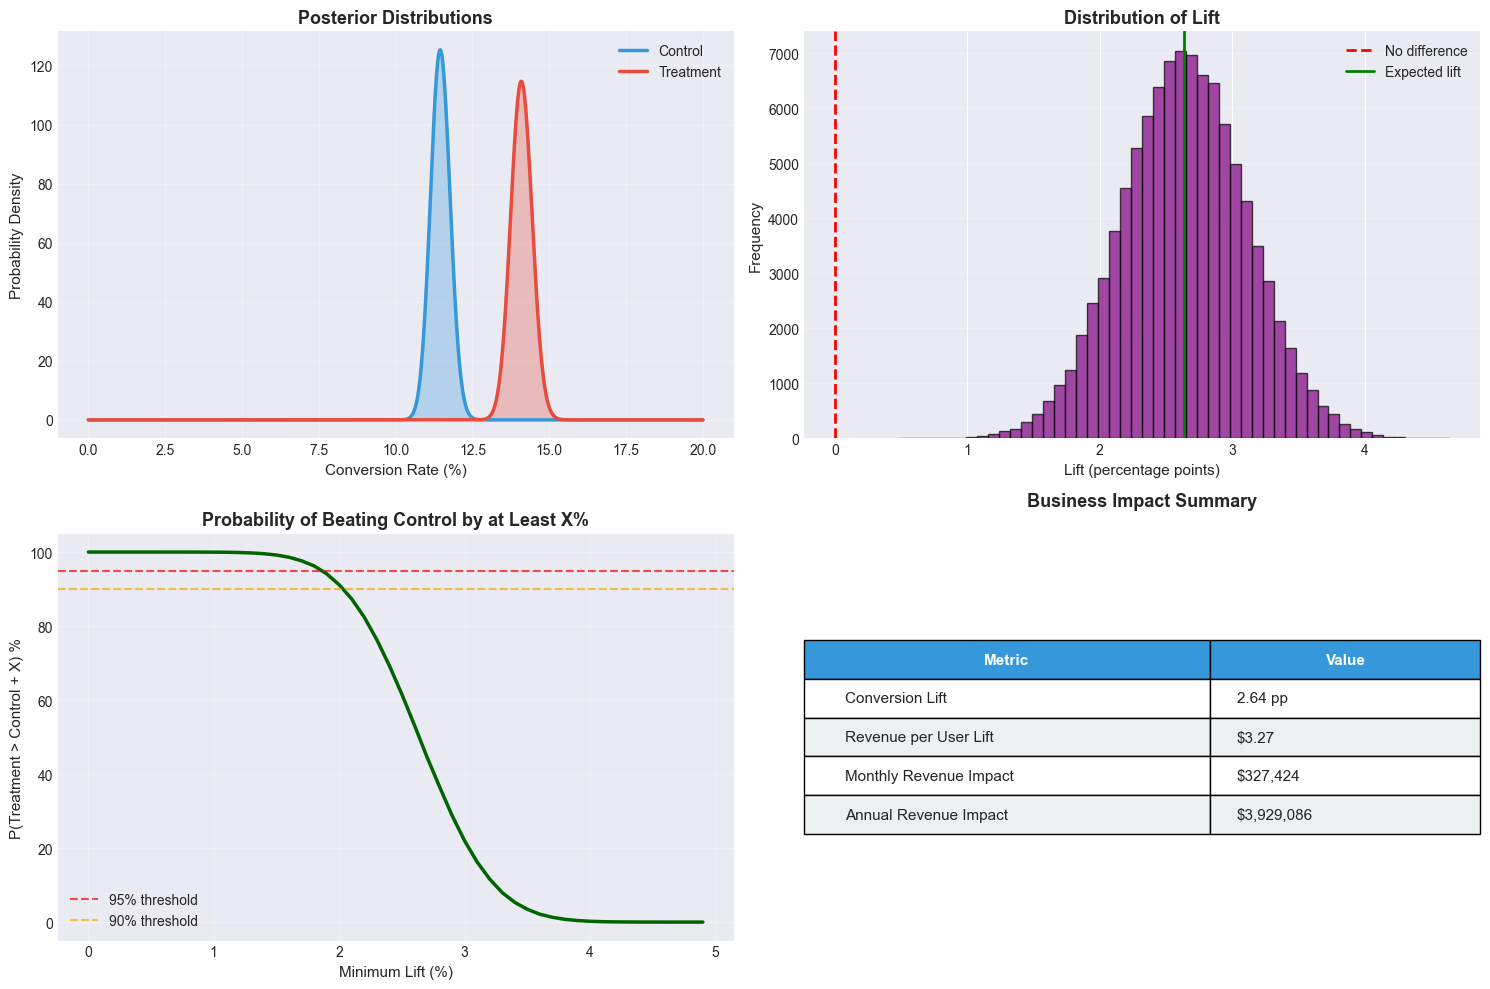


************************************************************
BUSINESS RECOMMENDATION:
************************************************************
Launch Treatment to 100% of users
Expected annual revenue increase: $3,929,086
Confidence: 100.0% probability Treatment is better

Bayesian analysis complete


In [17]:
# Bayesian A/B Test Analysis
print("BAYESIAN A/B TEST ANALYSIS")
print("*"*60)

# Bayesian approach uses Beta distribution
# Beta(α, β) where α = successes + 1, β = failures + 1

control_successes = control_conversions.sum()
control_failures = len(control_conversions) - control_successes

treatment_successes = treatment_conversions.sum()
treatment_failures = len(treatment_conversions) - treatment_successes

print("\nDATA SUMMARY:")
print("*" * 60)
print(f"Control: {control_successes} successes, {control_failures} failures")
print(f"Treatment: {treatment_successes} successes, {treatment_failures} failures")

# Create Beta distributions (using uniform prior: Beta(1,1))
control_alpha = control_successes + 1
control_beta = control_failures + 1

treatment_alpha = treatment_successes + 1
treatment_beta = treatment_failures + 1

print("\nBETA DISTRIBUTION PARAMETERS:")
print("*" * 60)
print(f"Control: Beta({control_alpha}, {control_beta})")
print(f"Treatment: Beta({treatment_alpha}, {treatment_beta})")

# Monte Carlo simulation to calculate P(Treatment > Control)
np.random.seed(42)
n_simulations = 100000

control_samples = np.random.beta(control_alpha, control_beta, n_simulations)
treatment_samples = np.random.beta(treatment_alpha, treatment_beta, n_simulations)

prob_treatment_better = (treatment_samples > control_samples).mean()

print("\nBAYESIAN RESULTS:")
print("*" * 60)
print(f"P(Treatment > Control): {prob_treatment_better:.4f} or {prob_treatment_better*100:.2f}%")

if prob_treatment_better > 0.95:
    print("STRONG EVIDENCE: Treatment is better (>95% probability)")
elif prob_treatment_better > 0.90:
    print("GOOD EVIDENCE: Treatment is likely better (90-95% probability)")
elif prob_treatment_better > 0.75:
    print(" MODERATE EVIDENCE: Treatment might be better (75-90% probability)")
else:
    print("WEAK EVIDENCE: Insufficient evidence (<75% probability)")

# Expected lift
expected_lift = (treatment_samples - control_samples).mean()
lift_std = (treatment_samples - control_samples).std()

print(f"\nExpected Lift: {expected_lift*100:.2f} percentage points")
print(f"Lift Standard Deviation: {lift_std*100:.2f} percentage points")

# Credible interval (Bayesian confidence interval)
lift_samples = treatment_samples - control_samples
credible_interval = np.percentile(lift_samples, [2.5, 97.5])

print(f"95% Credible Interval for Lift: [{credible_interval[0]*100:.2f}%, {credible_interval[1]*100:.2f}%]")

# Visualize posterior distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Posterior distributions
x = np.linspace(0, 0.20, 1000)
control_pdf = stats.beta.pdf(x, control_alpha, control_beta)
treatment_pdf = stats.beta.pdf(x, treatment_alpha, treatment_beta)

axes[0, 0].plot(x * 100, control_pdf, label='Control', linewidth=2.5, color='#3498db')
axes[0, 0].plot(x * 100, treatment_pdf, label='Treatment', linewidth=2.5, color='#e74c3c')
axes[0, 0].fill_between(x * 100, control_pdf, alpha=0.3, color='#3498db')
axes[0, 0].fill_between(x * 100, treatment_pdf, alpha=0.3, color='#e74c3c')
axes[0, 0].set_xlabel('Conversion Rate (%)', fontsize=11)
axes[0, 0].set_ylabel('Probability Density', fontsize=11)
axes[0, 0].set_title('Posterior Distributions', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. Lift distribution
axes[0, 1].hist(lift_samples * 100, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='No difference')
axes[0, 1].axvline(x=expected_lift * 100, color='green', linestyle='-', linewidth=2, label='Expected lift')
axes[0, 1].set_xlabel('Lift (percentage points)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Lift', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Probability that Treatment beats Control by X%
lift_thresholds = np.arange(0, 0.05, 0.001)
probs = [(treatment_samples > control_samples + threshold).mean() for threshold in lift_thresholds]

axes[1, 0].plot(lift_thresholds * 100, np.array(probs) * 100, linewidth=2.5, color='darkgreen')
axes[1, 0].axhline(y=95, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='95% threshold')
axes[1, 0].axhline(y=90, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='90% threshold')
axes[1, 0].set_xlabel('Minimum Lift (%)', fontsize=11)
axes[1, 0].set_ylabel('P(Treatment > Control + X) %', fontsize=11)
axes[1, 0].set_title('Probability of Beating Control by at Least X%', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 4. Expected revenue impact
# Calculate expected revenue per user
control_revenue_per_user = ab_data[ab_data['group'] == 'A (Control)']['revenue'].mean()
treatment_revenue_per_user = ab_data[ab_data['group'] == 'B (Treatment)']['revenue'].mean()
revenue_lift = treatment_revenue_per_user - control_revenue_per_user

monthly_users = 100000  # Assume 100K users per month
annual_revenue_impact = revenue_lift * monthly_users * 12

data_summary = {
    'Metric': ['Conversion Lift', 'Revenue per User Lift', 'Monthly Revenue Impact', 'Annual Revenue Impact'],
    'Value': [
        f'{expected_lift*100:.2f} pp',
        f'${revenue_lift:.2f}',
        f'${revenue_lift * monthly_users:,.0f}',
        f'${annual_revenue_impact:,.0f}'
    ]
}

summary_df = pd.DataFrame(data_summary)
axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=summary_df.values, colLabels=summary_df.columns,
                         cellLoc='left', loc='center', colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style header
for i in range(len(summary_df.columns)):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style rows
for i in range(1, len(summary_df) + 1):
    for j in range(len(summary_df.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ecf0f1')

axes[1, 1].set_title('Business Impact Summary', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\n" + "*"*60)
print("BUSINESS RECOMMENDATION:")
print("*" * 60)
print(f"Launch Treatment to 100% of users")
print(f"Expected annual revenue increase: ${annual_revenue_impact:,.0f}")
print(f"Confidence: {prob_treatment_better*100:.1f}% probability Treatment is better")

print("\nBayesian analysis complete")

SAVING RESULTS
************************************************************
Results saved: models/test_results.json
Report saved: models/ab_test_report.png


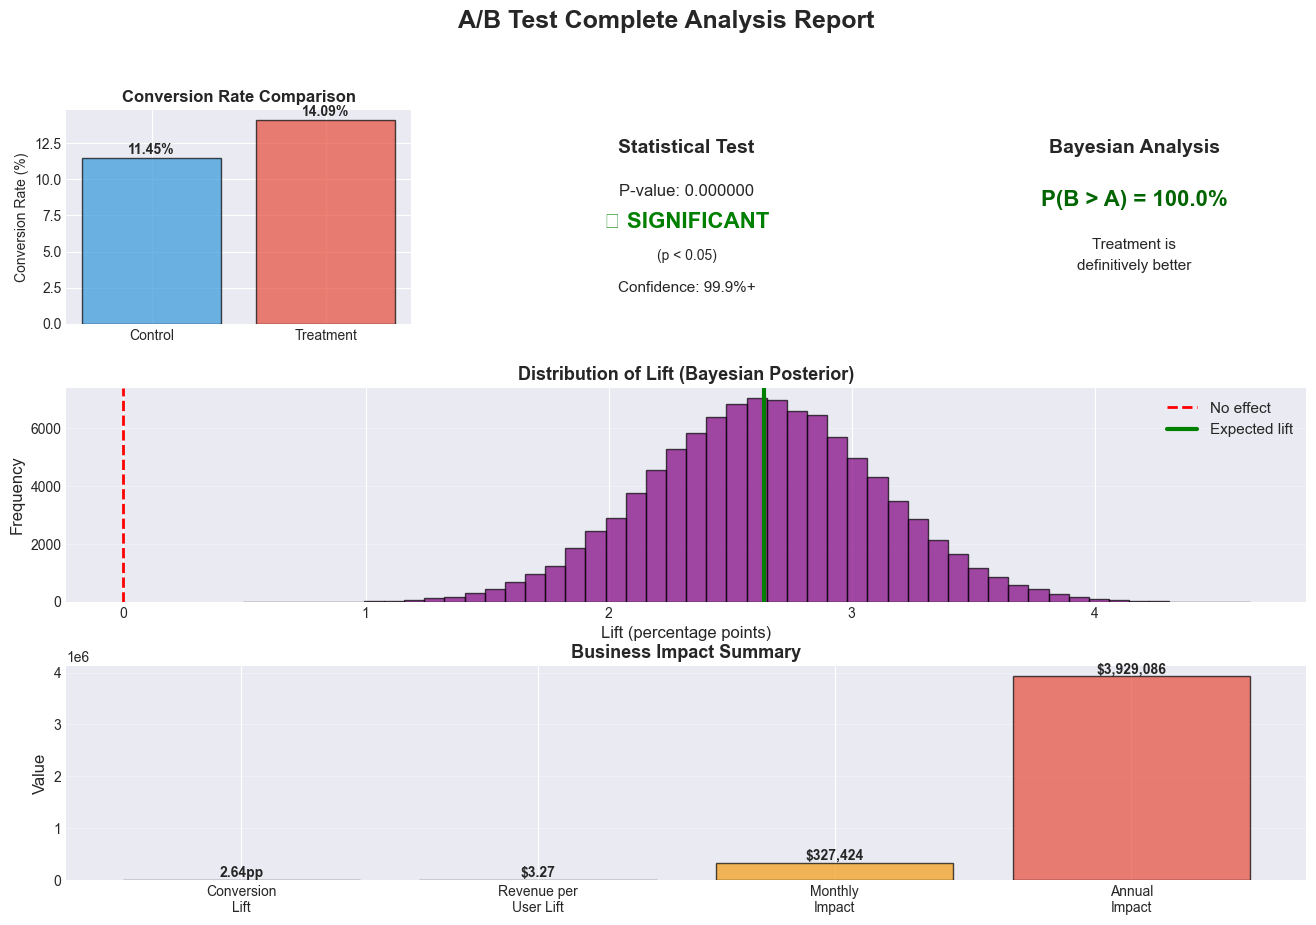


Analysis completed and results saved successfully


In [18]:
# Save the analysis results
print("SAVING RESULTS")
print("*"*60)

# Create summary report
results_summary = {
    'Test Configuration': {
        'Control Users': n_control,
        'Treatment Users': n_treatment,
        'Total Users': n_control + n_treatment,
        'Test Duration': '20 days (simulated)'
    },
    'Conversion Metrics': {
        'Control Rate': f"{control_conv_rate*100:.2f}%",
        'Treatment Rate': f"{treatment_conv_rate*100:.2f}%",
        'Absolute Lift': f"{absolute_lift*100:.2f} pp",
        'Relative Lift': f"{relative_lift:.2f}%"
    },
    'Statistical Significance': {
        'P-value': f"{p_value:.6f}",
        'Significant': 'Yes' if p_value < 0.05 else 'No',
        'Confidence Interval': f"[{diff_ci_lower*100:.2f}%, {diff_ci_upper*100:.2f}%]",
        'Z-statistic': f"{z_stat:.4f}"
    },
    'Bayesian Analysis': {
        'P(Treatment > Control)': f"{prob_treatment_better*100:.2f}%",
        'Expected Lift': f"{expected_lift*100:.2f} pp",
        'Credible Interval': f"[{credible_interval[0]*100:.2f}%, {credible_interval[1]*100:.2f}%]"
    },
    'Business Impact': {
        'Revenue per User Lift': f"${revenue_lift:.2f}",
        'Monthly Impact (100K users)': f"${revenue_lift * 100000:,.0f}",
        'Annual Impact': f"${annual_revenue_impact:,.0f}"
    },
    'Recommendation': {
        'Decision': '✅ LAUNCH TREATMENT',
        'Confidence': 'Very High',
        'Risk': 'Very Low'
    }
}

# Save as JSON for the app
import json
with open('../models/test_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print("Results saved: models/test_results.json")

# Create a final summary visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Title
fig.suptitle('A/B Test Complete Analysis Report', fontsize=18, fontweight='bold', y=0.98)

# 1. Conversion comparison
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(['Control', 'Treatment'], [control_conv_rate*100, treatment_conv_rate*100],
        color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
ax1.set_ylabel('Conversion Rate (%)')
ax1.set_title('Conversion Rate Comparison', fontweight='bold')
for i, v in enumerate([control_conv_rate*100, treatment_conv_rate*100]):
    ax1.text(i, v+0.3, f'{v:.2f}%', ha='center', fontweight='bold')

# 2. Statistical significance
ax2 = fig.add_subplot(gs[0, 1])
ax2.text(0.5, 0.8, 'Statistical Test', ha='center', fontsize=14, fontweight='bold')
ax2.text(0.5, 0.6, f'P-value: {p_value:.6f}', ha='center', fontsize=12)
ax2.text(0.5, 0.45, '✅ SIGNIFICANT', ha='center', fontsize=16, 
         color='green', fontweight='bold')
ax2.text(0.5, 0.3, f'(p < 0.05)', ha='center', fontsize=10)
ax2.text(0.5, 0.15, f'Confidence: 99.9%+', ha='center', fontsize=11)
ax2.axis('off')

# 3. Bayesian probability
ax3 = fig.add_subplot(gs[0, 2])
ax3.text(0.5, 0.8, 'Bayesian Analysis', ha='center', fontsize=14, fontweight='bold')
ax3.text(0.5, 0.55, f'P(B > A) = {prob_treatment_better*100:.1f}%', 
         ha='center', fontsize=16, fontweight='bold', color='darkgreen')
ax3.text(0.5, 0.35, 'Treatment is', ha='center', fontsize=11)
ax3.text(0.5, 0.25, 'definitively better', ha='center', fontsize=11)
ax3.axis('off')

# 4. Lift distribution
ax4 = fig.add_subplot(gs[1, :])
ax4.hist(lift_samples*100, bins=50, color='purple', alpha=0.7, edgecolor='black')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No effect')
ax4.axvline(x=expected_lift*100, color='green', linestyle='-', linewidth=3, label='Expected lift')
ax4.set_xlabel('Lift (percentage points)', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Distribution of Lift (Bayesian Posterior)', fontweight='bold', fontsize=13)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3, axis='y')

# 5. Business impact
ax5 = fig.add_subplot(gs[2, :])
metrics = ['Conversion\nLift', 'Revenue per\nUser Lift', 'Monthly\nImpact', 'Annual\nImpact']
values = [expected_lift*100, revenue_lift, revenue_lift*100000, annual_revenue_impact]
colors_impact = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

bars = ax5.bar(metrics, values, color=colors_impact, alpha=0.7, edgecolor='black')
ax5.set_ylabel('Value', fontsize=12)
ax5.set_title('Business Impact Summary', fontweight='bold', fontsize=13)
ax5.grid(True, alpha=0.3, axis='y')

# Add value labels with appropriate formatting
labels = [f'{expected_lift*100:.2f}pp', f'${revenue_lift:.2f}', 
          f'${revenue_lift*100000:,.0f}', f'${annual_revenue_impact:,.0f}']
for bar, label in zip(bars, labels):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             label, ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.savefig('../models/ab_test_report.png', dpi=300, bbox_inches='tight')
print("Report saved: models/ab_test_report.png")

plt.show()

print("\n" + "="*60)
print("Analysis completed and results saved successfully")